In [28]:
# Install core libraries
!pip install -q transformers sentence-transformers faiss-cpu langchain gradio chromadb qdrant-client

In [29]:
# Mount Drive for access to your knowledge base and saved models/indexes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!pip install -U langchain-community

In [31]:
import os
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

HKUST_Course_Advisor_PATH = "/content/drive/MyDrive/HKUST_Course_Advisor_Knowledge_Base"

files = [os.path.join(dp, f) for dp, _, fn in os.walk(HKUST_Course_Advisor_PATH ) for f in fn if f.endswith(".md")]
docs = [doc for f in files for doc in TextLoader(f, encoding="utf-8").load()]

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
texts = [chunk.page_content for chunk in chunks]
print(f"✅ {len(chunks)} chunks generated.")

✅ 238 chunks generated.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

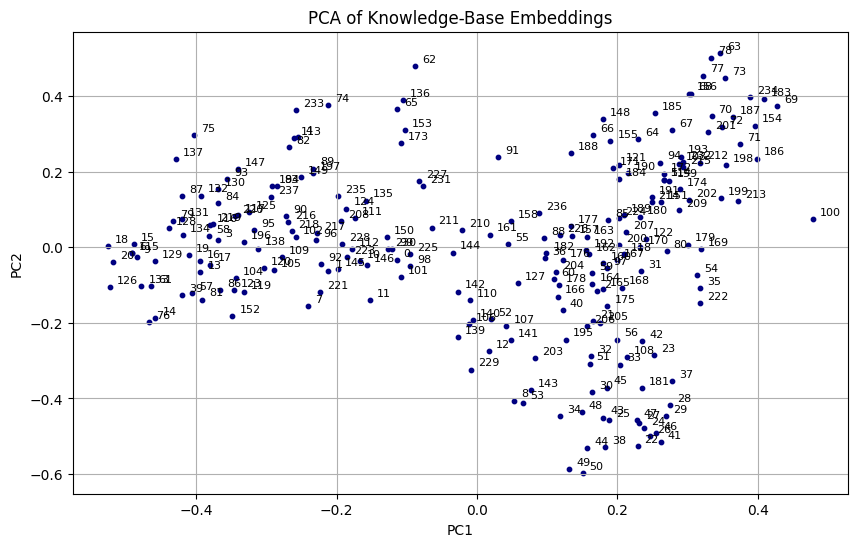

In [32]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Embed all chunks
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = [chunk.page_content for chunk in chunks]
embeddings = embed_model.encode(texts, show_progress_bar=True)

# 2. PCA to 2 dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# 3. Plot
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(reduced):
    plt.scatter(x, y, s=10, c="navy")
    plt.text(x + 0.01, y + 0.01, str(i), fontsize=8)
plt.title("PCA of Knowledge-Base Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [33]:
import faiss
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

# 1. Raw FAISS index
dim = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(np.array(embeddings, dtype="float32"))

# 2. Prepare LangChain wrapper
docs = [Document(page_content=t) for t in texts]
docstore = InMemoryDocstore({str(i): docs[i] for i in range(len(docs))})
id_map = {i: str(i) for i in range(len(docs))}
embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore_faiss = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)

print("✅ FAISS vectorstore ready.")


✅ FAISS vectorstore ready.


In [34]:
query = "things i need to know to make me decide"
results = vectorstore_faiss.similarity_search(query, k=3)

print("Top-3 FAISS Results:")
for i, doc in enumerate(results):
    print(f"\n— Passage {i+1}:\n{doc.page_content[:300]}…")


Top-3 FAISS Results:

— Passage 1:
## Relevant Information for Prospective Students

### Benefits of Participation
- **Cultural Enrichment**: Gain exposure to diverse cultures and traditions, enhancing your global perspective.
- **Skill Development**: Develop leadership, teamwork, and communication skills through active participation…

— Passage 2:
- **Participation**: Students and faculty are encouraged to participate in events, fostering a sense of community and collaboration across disciplines.

- **Event Registration**: Information on how to register for events is provided on the university's events page, with details on any associated cos…

— Passage 3:
### Application Documents
- **Official Transcripts**: Required from all previous institutions attended.
- **Statement of Purpose**: A detailed essay outlining research interests, career goals, and reasons for choosing HKUST.
- **Letters of Recommendation**: Typically two or three letters from academ…


In [35]:
import chromadb
from chromadb.config import Settings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

# 1. Initialize persistent client (will create `chroma_data/` locally)
client = chromadb.PersistentClient(
    path="chroma_data",
    settings=Settings()
)

# 2. Create or load a collection named "insurellm"
collection = client.get_or_create_collection(
    name="HKUST",
    embedding_function=SentenceTransformerEmbeddingFunction(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
)

# 3. Upsert your chunks (ids + documents)
ids = [str(i) for i in range(len(texts))]
collection.upsert(
    ids=ids,
    documents=texts
)

# 4. Query for top-3 similar passages
query = "Describe HKUST"
resp = collection.query(
    query_texts=[query],
    n_results=3
)
print("Top-3 ChromaDB Results:")
for doc in resp["documents"][0]:
    print("-", doc[:200].replace("\n"," "), "…")


Top-3 ChromaDB Results:
- # Facts & Figures about HKUST ### Overview HKUST is known for its commitment to academic excellence, innovative research, and international engagement, making it a leading institution in Asia and beyo …
- - **Core Values**: HKUST is guided by values of Innovation, Integrity, Excellence, Diversity, and Sustainability. These values shape academic programs, research initiatives, and community engagement a …
- # # Library Services at HKUST - **Overview**: The HKUST Library provides extensive resources and services to support academic research and learning. It houses a vast collection of books, journals, and …


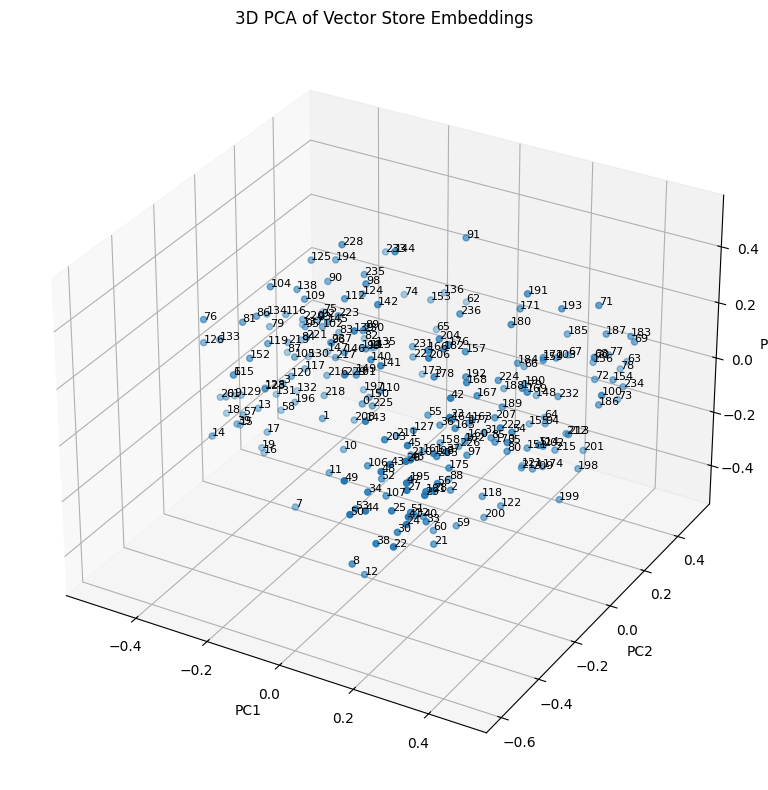

In [36]:
# 3D PCA Visualization of Your Vector Store Embeddings

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Extract FAISS index
faiss_idx = vectorstore_faiss.index
n = faiss_idx.ntotal

# 2. Reconstruct all vectors
emb_arr = np.vstack([faiss_idx.reconstruct(i) for i in range(n)])

# 3. Reduce to 3D
pca3 = PCA(n_components=3)
embeddings_3d = pca3.fit_transform(emb_arr)

# 4. Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2]
ax.scatter(xs, ys, zs)

# Annotate each point with its index
for i in range(n):
    ax.text(xs[i], ys[i], zs[i], str(i), fontsize=8)

ax.set_title("3D PCA of Vector Store Embeddings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()
